In [1]:
import os
import sys

import sparknlp

from sparknlp.base import *
from sparknlp.common import *
from sparknlp.annotator import *

from pyspark.ml import Pipeline
from pyspark.sql import SparkSession, Row

import pandas as pd
import numpy as np
import seaborn as sns

spark = sparknlp.start()

print("Spark NLP version: ", sparknlp.version())
print("Apache Spark version: ", spark.version)

spark

Spark NLP version:  4.0.1
Apache Spark version:  3.0.3


In [98]:
from scipy import spatial

In [5]:
titleDF = spark.read \
      .option("header", True) \
      .csv("data/training_all_data.csv", sep=r'@')

In [93]:
def get_model(data=None):
    
    document_assembler = DocumentAssembler()
    document_assembler.setInputCol('sentence')
    document_assembler.setOutputCol('sentence')
    
    embeddings = RoBertaSentenceEmbeddings.pretrained("sent_distilroberta_base", "en") \
      .setInputCols("sentence") \
      .setOutputCol("embeddings")

    pipeline = Pipeline(stages=[document_assembler, embeddings])
    
    if data is None:
        data = spark.createDataFrame([[""]]).toDF("sentence")

    pipeline = pipeline.fit(data)
    return pipeline

In [103]:
def get_similarity(input_list, pipeline):
    df = spark.createDataFrame(pd.DataFrame({'sentence': input_list}))
    result = pipeline.transform(df)
    embeddings = []
    for r in result.collect():
        embeddings.append(r.embeddings[0].embeddings)
    embeddings_matrix = np.array(embeddings)
    cos_similarity = []
    for embedding in embeddings_matrix:
        temp_lst = []
        for other_embedding in embeddings_matrix:
            temp_lst.append(1 - spatial.distance.cosine(embedding, other_embedding))
        cos_similarity.append(temp_lst)

    return cos_similarity

In [102]:
def plot_similarity(input_list, pipeline):
    g = sns.heatmap(
        get_similarity(input_list, pipeline),
        xticklabels=input_list,
        yticklabels=input_list,
        vmin=0,
        vmax=1,
        cmap="YlOrRd")
    g.set_xticklabels(input_list, rotation=90)
    g.set_title("Semantic Textual Similarity")

In [100]:
titles_str = ['data scientist','full stack developer', 'machine learning engineer','coach',"ml engineer","cleaner","writer","architector"]


In [96]:
pipeline = get_model()

sent_distilroberta_base download started this may take some time.
Approximate size to download 294.5 MB
[OK!]


In [106]:
get_similarity(titles_str, pipeline)

[[1.0,
  0.9735149003910449,
  0.9771281120903189,
  0.9692317877836188,
  0.972986864746274,
  0.9739099346482138,
  0.9545214578013763,
  0.9734894153570972],
 [0.9735149003910449,
  1.0,
  0.9841360124189009,
  0.9783395802578673,
  0.9877073744502342,
  0.9803011233470791,
  0.9551384121154634,
  0.9828522413624884],
 [0.9771281120903189,
  0.9841360124189009,
  1.0,
  0.9883560608006032,
  0.9907269531742529,
  0.9920654474234819,
  0.9670465438237467,
  0.9923192512849509],
 [0.9692317877836188,
  0.9783395802578673,
  0.9883560608006032,
  1.0,
  0.9888769633081811,
  0.9906104186698705,
  0.9632490649682217,
  0.9923368260644007],
 [0.972986864746274,
  0.9877073744502342,
  0.9907269531742529,
  0.9888769633081811,
  1.0,
  0.9907040801707819,
  0.9639847554842566,
  0.9911892554077876],
 [0.9739099346482138,
  0.9803011233470791,
  0.9920654474234819,
  0.9906104186698705,
  0.9907040801707819,
  1.0,
  0.9697098644456922,
  0.9946766974438934],
 [0.9545214578013763,
  0.9551

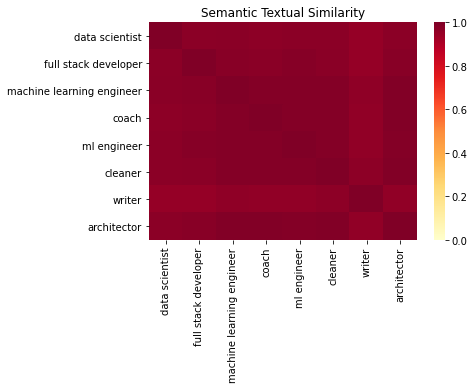

In [104]:
plot_similarity(titles_str, pipeline)

## Titles

In [105]:
titles = titleDF.drop('description')

In [107]:
titles_pipeline = get_model(titles.toDF('sentence'))

sent_distilroberta_base download started this may take some time.
Approximate size to download 294.5 MB
[OK!]


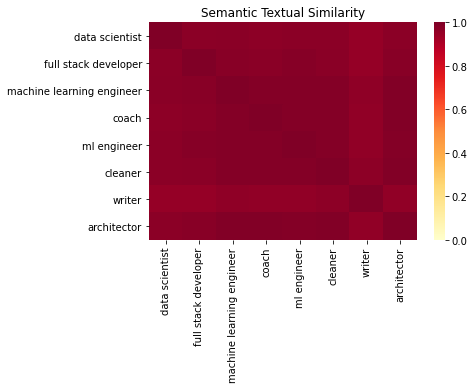

In [108]:
plot_similarity(titles_str, titles_pipeline)

## Description

In [109]:
description = titleDF.drop('title')

In [110]:
description_pipeline = get_model(titles.toDF('sentence'))

sent_distilroberta_base download started this may take some time.
Approximate size to download 294.5 MB
[OK!]


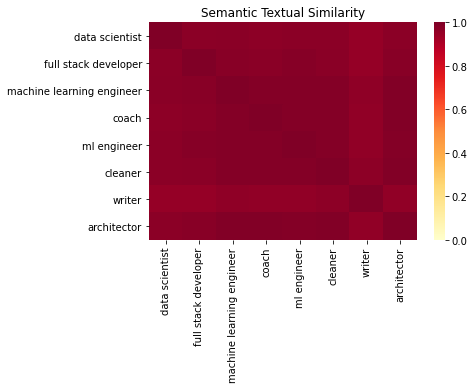

In [111]:
plot_similarity(titles_str, description_pipeline)